# Predicting and Explaining Employee Turnover at a Hotel Chain

Our objective is to train and evaluate a predictive model that predicts whether employees intend to stay or leave this chain of hotels. We also want to understand which factors explain employees' intention to stay or leave. 

## Notebook Styling and Package Management

In [54]:
import numpy as np # Library for math operations
import pandas as pd # Library for data handling
import sklearn # The machine learning library we will be using in this entire course
from sklearn import tree # Tree function is used for visualizing decision tree
from sklearn.metrics import * # Importing function that can be used to calculate different metrics
from sklearn.tree import DecisionTreeClassifier # Importing Decision Tree Classifier 
from sklearn.ensemble import RandomForestClassifier  # Importing Random Forest Classifier 
from sklearn.model_selection import train_test_split # Importing function that can split a dataset into training and testing set
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler # Importing function for scaling the data
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV # Importing GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve
from xgboost import XGBClassifier # Importing the XGBoost Classifier 
import matplotlib.pyplot as plt # Importing the package for plotting
plt.style.use('fivethirtyeight') # Use the styling from FiveThirtyEight Website
import seaborn as sns # Importing another package for plotting

In [55]:
from custom_functions import plot_conf_mat, plot_roc_curve, plot_feature_importance, calculateMetricsAndPrint

In [3]:
%matplotlib inline

In [4]:
pip install --upgrade scikit-learn

  Using cached scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
Using cached scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.5 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.2
    Uninstalling scikit-learn-1.5.2:
      Successfully uninstalled scikit-learn-1.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
pycaret 3.3.1 requires matplotlib<3.8.0, but you have matplotlib 3.9.1 which is incompatible.
scikit-survival 0.23.1 requires scikit-learn<1.6,>=1.4.0, but you have scikit-learn 1.6.1 which is incompatible.
sktime 0.26.0 requires scikit-learn<1.5.0,>=0.24, but you have scikit-learn 1.6.1 which is incompatible.
Note: you 

In [5]:
%%capture --no-display
!pip install mljar-supervised optuna xgboost catboost

In [6]:
from supervised.automl import AutoML

In [7]:
import optuna

In [8]:
from optuna.samplers import TPESampler

## Load Data

Our test and train sets are already split. We need to load those datasets into the notebook and drop `IntentToStayHL`, as that is what we are predicting.

In [9]:
trainInput = pd.read_csv("") 
testInput = pd.read_csv("")

Removing our dependent variable:

In [10]:
trainData = trainInput.drop(columns = ['State','IntentToStayHL'])
trainLabels = LabelEncoder().fit_transform(trainInput.IntentToStayHL)

testData = testInput.drop(columns = ['State','IntentToStayHL'])
testLabels = LabelEncoder().fit_transform(testInput.IntentToStayHL)

In [11]:
trainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7602 entries, 0 to 7601
Data columns (total 62 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Inncode              7602 non-null   int64  
 1   Generation           7602 non-null   float64
 2   Department           7602 non-null   int64  
 3   FullTimePartTime     7602 non-null   float64
 4   Tenure               7602 non-null   float64
 5   ManagementLevel      7602 non-null   int64  
 6   Engage1              7602 non-null   int64  
 7   Engage2              7602 non-null   int64  
 8   RecommendToOthers    7602 non-null   int64  
 9   CSR                  7602 non-null   int64  
 10  DEIB1                7602 non-null   int64  
 11  Informed             7602 non-null   int64  
 12  TeamFeeling          7602 non-null   int64  
 13  AppreciatedAtWork    7602 non-null   int64  
 14  TrustTeammates       7602 non-null   int64  
 15  Voice                7602 non-null   i

## MLJAR AutoML with Optuna

Here, we are using MLJAR AutoML with an external Optuna study (versus having `mode="Optuna"` inside of the objective function), allowing us to use `Compete` mode with `feature_selection` and `golden_features` in addition to Optuna to identify the best model type and hyperparameters. Sources used for the code and figuring out which settings would lead to the best score include [MLJAR Blog](https://mljar.com/blog/automl-optuna/) and this [GitHub page](https://github.com/mljar/mljar-supervised).

We attempted several feature engineering and data augmentation techniques to optimize the data for our model, including taking the log of `Engagement` and `Recommend to Others`; treating rare categories; dropping correlated columns; including various formulas; and more. However, everything we tried combined or by itself only increased our log-loss - the opposite of what we wanted. Because of this, we left the data as is and let AutoML decide what was best.

First, we define the objective function for Optuna, which optimizes the choice between XGBoost and CatBoost using MLJAR AutoML. For each trial, it initializes and trains the selected model with 5-fold cross-validation, optimizing for log-loss. The trained model makes predictions on our test set, and metrics (accuracy, precision, recall, AUC, and log loss) are computed and returned. Finally, the log loss score is returned, allowing Optuna to minimize it and find the best-performing model.

In [13]:
# BEST SO FAR - DON'T DELETE OR EDIT
def objective(trial):
    # Select model type
    model_choice = trial.suggest_categorical("model_type", ["Xgboost", "CatBoost"])

    # Create a unique results path for each trial
    results_path = f"MLJAR_Model4_trial_{trial.number}"
    
    # Initialize and train AutoML
    automl = AutoML(
        results_path=results_path,
        algorithms=[model_choice],  
        mode="Compete",  # Enables feature selection & golden features automatically
        total_time_limit=600,  # Limit total search time
        validation_strategy={"validation_type": "kfold", "k_folds": 5},
        eval_metric="logloss"  # Optimize for LogLoss
    )
    
    automl.fit(trainData, trainLabels)
    
    # Make predictions
    pred_probs = automl.predict_proba(testData)
    pred_labels = automl.predict(testData)
    
    # Compute metrics
    accuracy = accuracy_score(testLabels, pred_labels)
    precision_positive = precision_score(testLabels, pred_labels, pos_label=1)
    precision_negative = precision_score(testLabels, pred_labels, pos_label=0)
    recall_positive = recall_score(testLabels, pred_labels, pos_label=1)
    recall_negative = recall_score(testLabels, pred_labels, pos_label=0)
    auc_score = roc_auc_score(testLabels, pred_probs[:, 1])
    log_loss_score = log_loss(testLabels, pred_probs)
    
    # Print metrics
    print(f"Model: {model_choice}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Positive): {precision_positive:.4f}")
    print(f"Precision (Negative): {precision_negative:.4f}")
    print(f"Recall (Positive): {recall_positive:.4f}")
    print(f"Recall (Negative): {recall_negative:.4f}")
    print(f"AUC Score: {auc_score:.4f}")
    print(f"Log Loss: {log_loss_score:.4f}")
    print("-" * 50)
    
    return log_loss_score  # Optuna minimizes this score

Now we initiate an Optuna study to find the best model configuration by minimizing the log-loss. We're running the objective function for 20 trials, testing different model choices and configurations. After optimization, it prints the best parameters found during the process.

In [14]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# Display best parameters
print("Best Parameters:", study.best_params)

[I 2025-03-04 13:28:58,808] A new study created in memory with name: no-name-b4ece9cf-cd67-4db8-98cc-ae77ea897d64


AutoML directory: MLJAR_Model4_trial_0
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['CatBoost']
AutoML will stack models
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'kmeans_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'boost_on_errors', 'ensemble', 'stack', 'ensemble_stacked']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 1 model
1_Default_CatBoost logloss 0.333002 trained in 4.99 seconds
* Step not_so_random will try to check up to 9 models
2_CatBoost logloss 0.329836 trained in 5.93 seconds
3_CatBoost logloss 0.332115 trained in 4.97 seconds
4_CatBoost logloss 0.333621 trained in 4.65 seconds
5_CatBoost logloss 0.33805 trained in 4.51 seconds
6_CatBoost logloss 0.331708 trained in 4.67 seconds
7_CatBoost logloss 0.3333 trained in 4.8 s

[I 2025-03-04 13:37:11,408] Trial 0 finished with value: 0.32989160170418025 and parameters: {'model_type': 'CatBoost'}. Best is trial 0 with value: 0.32989160170418025.


Model: CatBoost
Accuracy: 0.8463
Precision (Positive): 0.8409
Precision (Negative): 0.8522
Recall (Positive): 0.8601
Recall (Negative): 0.8321
AUC Score: 0.9330
Log Loss: 0.3299
--------------------------------------------------
AutoML directory: MLJAR_Model4_trial_1
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Xgboost']
AutoML will stack models
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'kmeans_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'boost_on_errors', 'ensemble', 'stack', 'ensemble_stacked']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 1 model
1_Default_Xgboost logloss 0.334782 trained in 6.04 seconds
* Step not_so_random will try to check up to 9 models
2_Xgboost logloss 0.334704 trained in 4.65 seconds
3_Xgboost logloss 0.343

[I 2025-03-04 13:42:24,819] Trial 1 finished with value: 0.33234385328556937 and parameters: {'model_type': 'Xgboost'}. Best is trial 0 with value: 0.32989160170418025.


Model: Xgboost
Accuracy: 0.8476
Precision (Positive): 0.8416
Precision (Negative): 0.8542
Recall (Positive): 0.8623
Recall (Negative): 0.8325
AUC Score: 0.9322
Log Loss: 0.3323
--------------------------------------------------
AutoML directory: MLJAR_Model4_trial_2
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['CatBoost']
AutoML will stack models
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'kmeans_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'boost_on_errors', 'ensemble', 'stack', 'ensemble_stacked']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 1 model
1_Default_CatBoost logloss 0.333002 trained in 6.21 seconds
* Step not_so_random will try to check up to 9 models
2_CatBoost logloss 0.329836 trained in 5.83 seconds
3_CatBoost logloss 0.

[I 2025-03-04 13:50:33,245] Trial 2 finished with value: 0.32989160170418025 and parameters: {'model_type': 'CatBoost'}. Best is trial 0 with value: 0.32989160170418025.


Model: CatBoost
Accuracy: 0.8463
Precision (Positive): 0.8409
Precision (Negative): 0.8522
Recall (Positive): 0.8601
Recall (Negative): 0.8321
AUC Score: 0.9330
Log Loss: 0.3299
--------------------------------------------------
AutoML directory: MLJAR_Model4_trial_3
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['CatBoost']
AutoML will stack models
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'kmeans_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'boost_on_errors', 'ensemble', 'stack', 'ensemble_stacked']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 1 model
1_Default_CatBoost logloss 0.333002 trained in 6.0 seconds
* Step not_so_random will try to check up to 9 models
2_CatBoost logloss 0.329836 trained in 5.81 seconds
3_CatBoost logloss 0.

[I 2025-03-04 13:58:47,119] Trial 3 finished with value: 0.32989160170418025 and parameters: {'model_type': 'CatBoost'}. Best is trial 0 with value: 0.32989160170418025.


Model: CatBoost
Accuracy: 0.8463
Precision (Positive): 0.8409
Precision (Negative): 0.8522
Recall (Positive): 0.8601
Recall (Negative): 0.8321
AUC Score: 0.9330
Log Loss: 0.3299
--------------------------------------------------
AutoML directory: MLJAR_Model4_trial_4
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Xgboost']
AutoML will stack models
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'kmeans_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'boost_on_errors', 'ensemble', 'stack', 'ensemble_stacked']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 1 model
1_Default_Xgboost logloss 0.334782 trained in 6.06 seconds
* Step not_so_random will try to check up to 9 models
2_Xgboost logloss 0.334704 trained in 4.61 seconds
3_Xgboost logloss 0.343

[I 2025-03-04 14:04:02,931] Trial 4 finished with value: 0.33234385328556937 and parameters: {'model_type': 'Xgboost'}. Best is trial 0 with value: 0.32989160170418025.


Model: Xgboost
Accuracy: 0.8476
Precision (Positive): 0.8416
Precision (Negative): 0.8542
Recall (Positive): 0.8623
Recall (Negative): 0.8325
AUC Score: 0.9322
Log Loss: 0.3323
--------------------------------------------------
AutoML directory: MLJAR_Model4_trial_5
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Xgboost']
AutoML will stack models
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'kmeans_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'boost_on_errors', 'ensemble', 'stack', 'ensemble_stacked']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 1 model
1_Default_Xgboost logloss 0.334782 trained in 6.4 seconds
* Step not_so_random will try to check up to 9 models
2_Xgboost logloss 0.334704 trained in 4.87 seconds
3_Xgboost logloss 0.34361

[I 2025-03-04 14:09:17,838] Trial 5 finished with value: 0.33234385328556937 and parameters: {'model_type': 'Xgboost'}. Best is trial 0 with value: 0.32989160170418025.


Model: Xgboost
Accuracy: 0.8476
Precision (Positive): 0.8416
Precision (Negative): 0.8542
Recall (Positive): 0.8623
Recall (Negative): 0.8325
AUC Score: 0.9322
Log Loss: 0.3323
--------------------------------------------------
AutoML directory: MLJAR_Model4_trial_6
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Xgboost']
AutoML will stack models
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'kmeans_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'boost_on_errors', 'ensemble', 'stack', 'ensemble_stacked']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 1 model
1_Default_Xgboost logloss 0.334782 trained in 6.13 seconds
* Step not_so_random will try to check up to 9 models
2_Xgboost logloss 0.334704 trained in 4.74 seconds
3_Xgboost logloss 0.3436

[I 2025-03-04 14:14:31,775] Trial 6 finished with value: 0.33234385328556937 and parameters: {'model_type': 'Xgboost'}. Best is trial 0 with value: 0.32989160170418025.


Model: Xgboost
Accuracy: 0.8476
Precision (Positive): 0.8416
Precision (Negative): 0.8542
Recall (Positive): 0.8623
Recall (Negative): 0.8325
AUC Score: 0.9322
Log Loss: 0.3323
--------------------------------------------------
AutoML directory: MLJAR_Model4_trial_7
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Xgboost']
AutoML will stack models
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'kmeans_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'boost_on_errors', 'ensemble', 'stack', 'ensemble_stacked']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 1 model
1_Default_Xgboost logloss 0.334782 trained in 6.24 seconds
* Step not_so_random will try to check up to 9 models
2_Xgboost logloss 0.334704 trained in 4.73 seconds
3_Xgboost logloss 0.3436

[I 2025-03-04 14:19:45,139] Trial 7 finished with value: 0.33234385328556937 and parameters: {'model_type': 'Xgboost'}. Best is trial 0 with value: 0.32989160170418025.


Model: Xgboost
Accuracy: 0.8476
Precision (Positive): 0.8416
Precision (Negative): 0.8542
Recall (Positive): 0.8623
Recall (Negative): 0.8325
AUC Score: 0.9322
Log Loss: 0.3323
--------------------------------------------------
AutoML directory: MLJAR_Model4_trial_8
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Xgboost']
AutoML will stack models
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'kmeans_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'boost_on_errors', 'ensemble', 'stack', 'ensemble_stacked']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 1 model
1_Default_Xgboost logloss 0.334782 trained in 6.22 seconds
* Step not_so_random will try to check up to 9 models
2_Xgboost logloss 0.334704 trained in 4.64 seconds
3_Xgboost logloss 0.3436

[I 2025-03-04 14:24:55,325] Trial 8 finished with value: 0.33234385328556937 and parameters: {'model_type': 'Xgboost'}. Best is trial 0 with value: 0.32989160170418025.


Model: Xgboost
Accuracy: 0.8476
Precision (Positive): 0.8416
Precision (Negative): 0.8542
Recall (Positive): 0.8623
Recall (Negative): 0.8325
AUC Score: 0.9322
Log Loss: 0.3323
--------------------------------------------------
AutoML directory: MLJAR_Model4_trial_9
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['CatBoost']
AutoML will stack models
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'kmeans_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'boost_on_errors', 'ensemble', 'stack', 'ensemble_stacked']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 1 model
1_Default_CatBoost logloss 0.333002 trained in 6.32 seconds
* Step not_so_random will try to check up to 9 models
2_CatBoost logloss 0.329836 trained in 6.01 seconds
3_CatBoost logloss 0.

[I 2025-03-04 14:33:09,634] Trial 9 finished with value: 0.32989160170418025 and parameters: {'model_type': 'CatBoost'}. Best is trial 0 with value: 0.32989160170418025.


Model: CatBoost
Accuracy: 0.8463
Precision (Positive): 0.8409
Precision (Negative): 0.8522
Recall (Positive): 0.8601
Recall (Negative): 0.8321
AUC Score: 0.9330
Log Loss: 0.3299
--------------------------------------------------
AutoML directory: MLJAR_Model4_trial_10
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['CatBoost']
AutoML will stack models
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'kmeans_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'boost_on_errors', 'ensemble', 'stack', 'ensemble_stacked']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 1 model
1_Default_CatBoost logloss 0.333002 trained in 6.31 seconds
* Step not_so_random will try to check up to 9 models
2_CatBoost logloss 0.329836 trained in 5.96 seconds
3_CatBoost logloss 

[I 2025-03-04 14:49:57,628] Trial 11 finished with value: 0.32989160170418025 and parameters: {'model_type': 'CatBoost'}. Best is trial 0 with value: 0.32989160170418025.


Model: CatBoost
Accuracy: 0.8463
Precision (Positive): 0.8409
Precision (Negative): 0.8522
Recall (Positive): 0.8601
Recall (Negative): 0.8321
AUC Score: 0.9330
Log Loss: 0.3299
--------------------------------------------------
AutoML directory: MLJAR_Model4_trial_12
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['CatBoost']
AutoML will stack models
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'kmeans_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'boost_on_errors', 'ensemble', 'stack', 'ensemble_stacked']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 1 model
1_Default_CatBoost logloss 0.333002 trained in 6.37 seconds
* Step not_so_random will try to check up to 9 models
2_CatBoost logloss 0.329836 trained in 6.09 seconds
3_CatBoost logloss 

[I 2025-03-04 14:58:31,645] Trial 12 finished with value: 0.32989160170418025 and parameters: {'model_type': 'CatBoost'}. Best is trial 0 with value: 0.32989160170418025.


Model: CatBoost
Accuracy: 0.8463
Precision (Positive): 0.8409
Precision (Negative): 0.8522
Recall (Positive): 0.8601
Recall (Negative): 0.8321
AUC Score: 0.9330
Log Loss: 0.3299
--------------------------------------------------
AutoML directory: MLJAR_Model4_trial_13
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['CatBoost']
AutoML will stack models
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'kmeans_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'boost_on_errors', 'ensemble', 'stack', 'ensemble_stacked']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 1 model
1_Default_CatBoost logloss 0.333002 trained in 6.23 seconds
* Step not_so_random will try to check up to 9 models
2_CatBoost logloss 0.329836 trained in 6.06 seconds
3_CatBoost logloss 

[I 2025-03-04 15:07:17,527] Trial 13 finished with value: 0.32989160170418025 and parameters: {'model_type': 'CatBoost'}. Best is trial 0 with value: 0.32989160170418025.


Model: CatBoost
Accuracy: 0.8463
Precision (Positive): 0.8409
Precision (Negative): 0.8522
Recall (Positive): 0.8601
Recall (Negative): 0.8321
AUC Score: 0.9330
Log Loss: 0.3299
--------------------------------------------------
AutoML directory: MLJAR_Model4_trial_14
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['CatBoost']
AutoML will stack models
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'kmeans_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'boost_on_errors', 'ensemble', 'stack', 'ensemble_stacked']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 1 model
1_Default_CatBoost logloss 0.333002 trained in 6.88 seconds
* Step not_so_random will try to check up to 9 models
2_CatBoost logloss 0.329836 trained in 6.36 seconds
3_CatBoost logloss 

[I 2025-03-04 15:15:48,461] Trial 14 finished with value: 0.32989160170418025 and parameters: {'model_type': 'CatBoost'}. Best is trial 0 with value: 0.32989160170418025.


Model: CatBoost
Accuracy: 0.8463
Precision (Positive): 0.8409
Precision (Negative): 0.8522
Recall (Positive): 0.8601
Recall (Negative): 0.8321
AUC Score: 0.9330
Log Loss: 0.3299
--------------------------------------------------
AutoML directory: MLJAR_Model4_trial_15
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['CatBoost']
AutoML will stack models
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'kmeans_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'boost_on_errors', 'ensemble', 'stack', 'ensemble_stacked']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 1 model
1_Default_CatBoost logloss 0.333002 trained in 6.21 seconds
* Step not_so_random will try to check up to 9 models
2_CatBoost logloss 0.329836 trained in 6.05 seconds
3_CatBoost logloss 

[I 2025-03-04 15:24:17,139] Trial 15 finished with value: 0.32989160170418025 and parameters: {'model_type': 'CatBoost'}. Best is trial 0 with value: 0.32989160170418025.


Model: CatBoost
Accuracy: 0.8463
Precision (Positive): 0.8409
Precision (Negative): 0.8522
Recall (Positive): 0.8601
Recall (Negative): 0.8321
AUC Score: 0.9330
Log Loss: 0.3299
--------------------------------------------------
AutoML directory: MLJAR_Model4_trial_16
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['CatBoost']
AutoML will stack models
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'kmeans_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'boost_on_errors', 'ensemble', 'stack', 'ensemble_stacked']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 1 model
1_Default_CatBoost logloss 0.333002 trained in 6.37 seconds
* Step not_so_random will try to check up to 9 models
2_CatBoost logloss 0.329836 trained in 6.02 seconds
3_CatBoost logloss 

[I 2025-03-04 15:32:56,054] Trial 16 finished with value: 0.32989160170418025 and parameters: {'model_type': 'CatBoost'}. Best is trial 0 with value: 0.32989160170418025.


Model: CatBoost
Accuracy: 0.8463
Precision (Positive): 0.8409
Precision (Negative): 0.8522
Recall (Positive): 0.8601
Recall (Negative): 0.8321
AUC Score: 0.9330
Log Loss: 0.3299
--------------------------------------------------
AutoML directory: MLJAR_Model4_trial_17
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['CatBoost']
AutoML will stack models
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'kmeans_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'boost_on_errors', 'ensemble', 'stack', 'ensemble_stacked']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 1 model
1_Default_CatBoost logloss 0.333002 trained in 8.12 seconds
* Step not_so_random will try to check up to 9 models
2_CatBoost logloss 0.329836 trained in 8.39 seconds
3_CatBoost logloss 

[I 2025-03-04 15:42:04,739] Trial 17 finished with value: 0.32989160170418025 and parameters: {'model_type': 'CatBoost'}. Best is trial 0 with value: 0.32989160170418025.


Model: CatBoost
Accuracy: 0.8463
Precision (Positive): 0.8409
Precision (Negative): 0.8522
Recall (Positive): 0.8601
Recall (Negative): 0.8321
AUC Score: 0.9330
Log Loss: 0.3299
--------------------------------------------------
AutoML directory: MLJAR_Model4_trial_18
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['CatBoost']
AutoML will stack models
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'kmeans_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'boost_on_errors', 'ensemble', 'stack', 'ensemble_stacked']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 1 model
1_Default_CatBoost logloss 0.333002 trained in 6.56 seconds
* Step not_so_random will try to check up to 9 models
2_CatBoost logloss 0.329836 trained in 6.19 seconds
3_CatBoost logloss 

[I 2025-03-04 15:50:39,779] Trial 18 finished with value: 0.32989160170418025 and parameters: {'model_type': 'CatBoost'}. Best is trial 0 with value: 0.32989160170418025.


Model: CatBoost
Accuracy: 0.8463
Precision (Positive): 0.8409
Precision (Negative): 0.8522
Recall (Positive): 0.8601
Recall (Negative): 0.8321
AUC Score: 0.9330
Log Loss: 0.3299
--------------------------------------------------
AutoML directory: MLJAR_Model4_trial_19
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['CatBoost']
AutoML will stack models
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'kmeans_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'boost_on_errors', 'ensemble', 'stack', 'ensemble_stacked']
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 1 model
1_Default_CatBoost logloss 0.333002 trained in 6.42 seconds
* Step not_so_random will try to check up to 9 models
2_CatBoost logloss 0.329836 trained in 6.13 seconds
3_CatBoost logloss 

[I 2025-03-04 15:59:26,027] Trial 19 finished with value: 0.32989160170418025 and parameters: {'model_type': 'CatBoost'}. Best is trial 0 with value: 0.32989160170418025.


Model: CatBoost
Accuracy: 0.8463
Precision (Positive): 0.8409
Precision (Negative): 0.8522
Recall (Positive): 0.8601
Recall (Negative): 0.8321
AUC Score: 0.9330
Log Loss: 0.3299
--------------------------------------------------
Best Parameters: {'model_type': 'CatBoost'}


In [15]:
print("Best Parameters:", study.best_params)
print("Best Value:", study.best_value)
print("Best Trial:", study.best_trial)

Best Parameters: {'model_type': 'CatBoost'}
Best Value: 0.32989160170418025
Best Trial: FrozenTrial(number=0, state=1, values=[0.32989160170418025], datetime_start=datetime.datetime(2025, 3, 4, 13, 28, 58, 809197), datetime_complete=datetime.datetime(2025, 3, 4, 13, 37, 11, 408248), params={'model_type': 'CatBoost'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'model_type': CategoricalDistribution(choices=('Xgboost', 'CatBoost'))}, trial_id=0, value=None)


Now, we retrieve the best hyperparameters from the Optuna study, extract the optimal model type (XGBoost or CatBoost - Catboost in our case), and format the parameters for MLJAR AutoML. We then train a final model using the optimized settings and 5-fold cross-validation. Once trained, the model is saved using pickle for future use, ensuring reproducibility of the best-found configuration.

In [16]:
import pickle

best_params = study.best_params
final_model_type = best_params.pop("model_type")

# Convert Optuna parameters to AutoML format
final_params = {}
if final_model_type == "Xgboost":
    final_params = {"Xgboost": best_params}
elif final_model_type == "Catboost":
    final_params = {"Catboost": best_params}

# Train final AutoML model
final_automl = AutoML(
    results_path="MLJAR_Model4_trial_19", # REMEMBER TO UPDATE "#" WITH THE NUMBER OF THE BEST TRIAL
    algorithms=[final_model_type],  
    mode="Compete",
    validation_strategy={"validation_type": "kfold", "k_folds": 5},
    eval_metric="logloss",
    **final_params  # Pass the optimized parameters here
)

# Fit the model with optimized hyperparameters
final_automl.fit(trainData, trainLabels)

# Save the trained model using pickle
with open("mljar_model.pkl", "wb") as f:
    pickle.dump(final_automl, f)

print("Model saved successfully as 'mljar_model.pkl'")

This model has already been fitted. You can use predict methods or select a new 'results_path' for a new 'fit()'.
Model saved successfully as 'mljar_model.pkl'


From here, we calculate all of our desired metrics for our model, including the final log-loss, confusion matrix, roc-auc graph, and more!

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# Predict labels and probabilities
y_pred = final_automl.predict(testData)
y_prob = final_automl.predict_proba(testData)[:, 1]  # Assuming binary classification

# Calculate metrics
accuracy = accuracy_score(testLabels, y_pred)
precision_neg = precision_score(testLabels, y_pred, pos_label=0)
precision_pos = precision_score(testLabels, y_pred, pos_label=1)
recall_neg = recall_score(testLabels, y_pred, pos_label=0)
recall_pos = recall_score(testLabels, y_pred, pos_label=1)
auc_score = roc_auc_score(testLabels, y_prob)
log_loss_score = log_loss(testLabels, y_prob)

# Print metrics
print(f"Accuracy: {accuracy * 100:.2f}")
print(f"PrecisionNegative: {precision_neg * 100:.2f}")
print(f"PrecisionPositive: {precision_pos * 100:.2f}")
print(f"RecallNegative: {recall_neg * 100:.2f}")
print(f"RecallPositive: {recall_pos * 100:.2f}")
print(f"AUC Score: {auc_score * 100:.2f}")
print(f"Log-Loss: {log_loss_score:.4f}")

Accuracy: 84.63
PrecisionNegative: 85.22
PrecisionPositive: 84.09
RecallNegative: 83.21
RecallPositive: 86.01
AUC Score: 93.30
Log-Loss: 0.3299


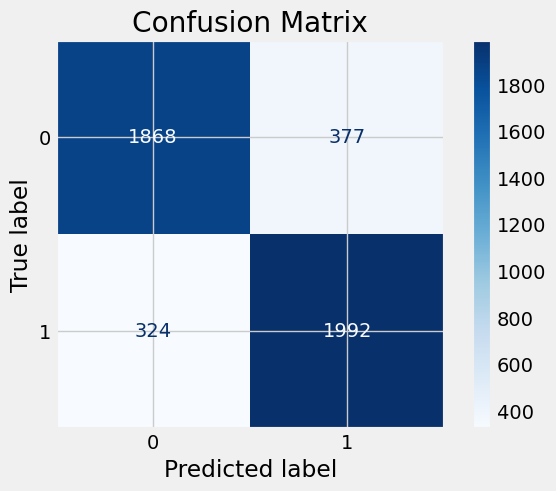

In [36]:
# Generate confusion matrix
cm = confusion_matrix(testLabels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

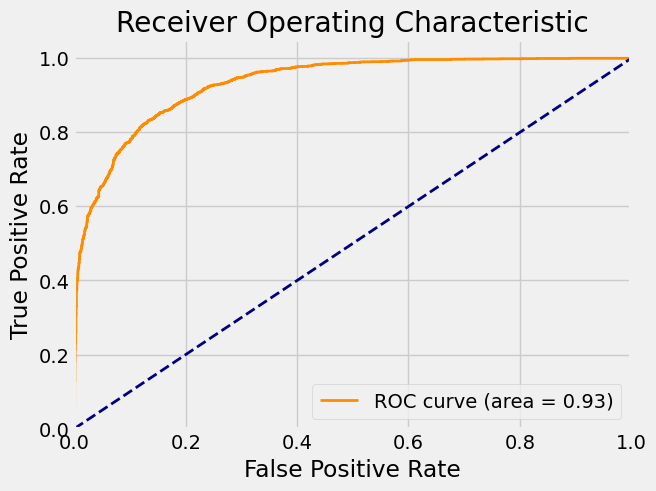

In [37]:
# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(testLabels, y_prob)
roc_auc = roc_auc_score(testLabels, y_prob)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [41]:
temp = pd.DataFrame({'prob_one': y_prob, 'Labels': testLabels})

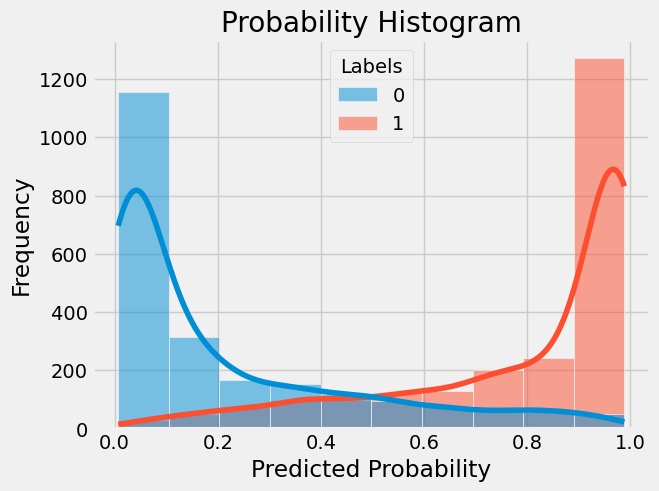

In [43]:
# Plot probability histogram
plt.figure()
sns.histplot(data=temp, x='prob_one', hue='Labels', bins=10, kde=True)
plt.title('Probability Histogram')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

## Apply the Model to Kaggle Data:

In [21]:
kaggleTest = pd.read_csv("Data/mod3_2025_kaggle.csv") 
temp = kaggleTest.drop(columns = ['State','unique_id'])

In [20]:
# Predict probabilities on test data
final_preds_proba = final_automl.predict_proba(temp)

# Due to binary classification, extract the probability of the positive class (second column)
kaggleTest['score'] = final_preds_proba[:, 1]

# Save the submission file
kaggleTest[['unique_id', 'score']].to_csv("Data/Kaggle_Submission.csv", index=False)

print("Submission file saved successfully.")

Submission file saved successfully.


Please submit to https://www.kaggle.com/t/b2331d7286e44ac5a18025445b9902e9

Each team should make at least three submissions per week from the launch until we close the competition. 

## XGBoost Model with HyperOpt

Now we'll train and XGBoost model using HyperOpt to use in our Hugging Face App. This simpler model allows for straightforward understanding and processing of employee's data when predicting their likelihood of staying or leaving this hotel chain.

First, we'll narrow down our train and test data sets to have only our 5 selected variables to train on.

In [32]:
#For the Web App
trainData = trainData[['Engagement','JobSecurity', 'WorkEnvironment','WellBeing','SupportiveGM']]
testData = testData[['Engagement','JobSecurity', 'WorkEnvironment','WellBeing','SupportiveGM']]

Once we install HyperOpt, we will give it a range of variables within each listed hyperparameter to search from to select the best value for each hyperparameter in the model.

In [33]:
!pip install hyperopt

  Using cached hyperopt-0.2.7-py2.py3-none-any.whl.metadata (1.7 kB)
  Using cached future-1.0.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached py4j-0.10.9.9-py2.py3-none-any.whl.metadata (1.3 kB)
Using cached hyperopt-0.2.7-py2.py3-none-any.whl (1.6 MB)
Using cached future-1.0.0-py3-none-any.whl (491 kB)
Using cached py4j-0.10.9.9-py2.py3-none-any.whl (203 kB)


In [34]:
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [35]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform('n_estimators', 100, 200, 20),
        'eta': hp.uniform ('eta', 0.1,0.9),
        'seed': 0,
        'random_state': 1
    }

In [37]:
from sklearn.metrics import roc_auc_score

def objective(space):
    clf=XGBClassifier(
        random_state = space['random_state'],
        eta = space['eta'],
        n_estimators = int(space['n_estimators']), 
        max_depth = int(space['max_depth']), 
        gamma = space['gamma'],
        reg_alpha = int(space['reg_alpha']),
        min_child_weight=int(space['min_child_weight']),
        colsample_bytree=int(space['colsample_bytree']), 
        eval_metric="auc",
        early_stopping_rounds=10)
    
    evaluation = [( trainData, trainLabels), ( testData, testLabels)]
    
    clf.fit(trainData, trainLabels,
            eval_set=evaluation,verbose=False)
    

    pred = clf.predict(testData)
    accuracy = roc_auc_score(testLabels, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [38]:
%%capture --no-display

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

In [39]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.8193044399019596, 'eta': 0.31023166340081954, 'gamma': 1.6489334450481488, 'max_depth': 11.0, 'min_child_weight': 5.0, 'n_estimators': 140.0, 'reg_alpha': 47.0, 'reg_lambda': 0.7764879892757248}


In [40]:
best_hyperparams = {
    'colsample_bytree': 0.8193044399019596, 
    'eta': 0.31023166340081954, 
    'gamma': 1.6489334450481488, 
    'max_depth': 11, # should be integer
    'min_child_weight': 5, # should be integer
    'n_estimators': 140, # should be integer
    'reg_alpha': 47.0, 
    'reg_lambda': 0.7764879892757248}

Now, we train our XGBoost classifier with those hyperparamters on our train dataset. Then, we'll test it on the test dataset and print out our metrics with corresponding graphs.

In [41]:
xgb = XGBClassifier(**best_hyperparams, random_state=1)
xgb.fit(trainData, trainLabels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8193044399019596, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.31023166340081954, eval_metric=None, feature_types=None,
              gamma=1.6489334450481488, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=140, n_jobs=None,
              num_parallel_tree=None, ...)

In [42]:
predictedProbabilities = xgb.predict_proba(testData)
predictedLabels = xgb.predict(testData) 
calculateMetricsAndPrint(predictedLabels, predictedProbabilities, testLabels)

Accuracy: 83.60
PrecisionNegative: 83.49
PrecisionPositive: 83.71
RecallNegative: 83.12
RecallPositive: 84.07
AUC Score: 91.93



In [43]:
%matplotlib inline

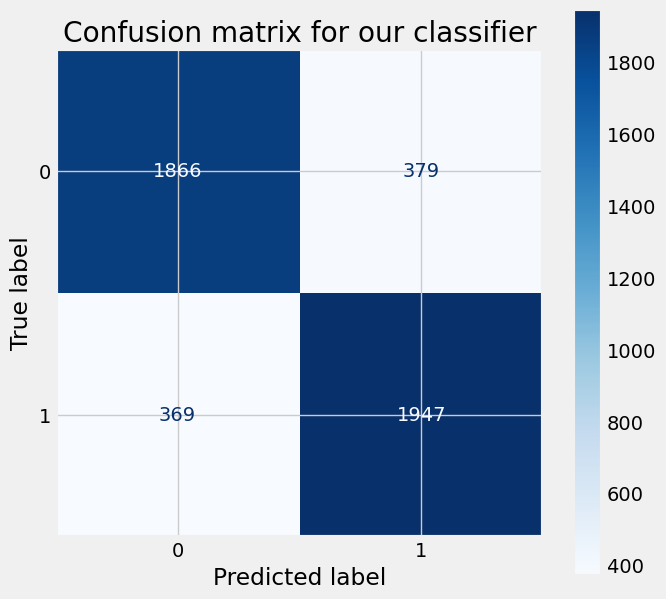

In [44]:
plot_conf_mat(xgb, # The classifier object
              testData, # The test data set aside for evaluation in train_test_split
              testLabels # Actual labels
             )

In [46]:
print("F1 Score:",f1_score(testLabels, predictedLabels, average='micro'))

F1 Score: 0.8360008770006577


In [47]:
predictedProbabilities

array([[0.06402516, 0.93597484],
       [0.4304337 , 0.5695663 ],
       [0.52742887, 0.4725711 ],
       ...,
       [0.9408984 , 0.05910157],
       [0.06402516, 0.93597484],
       [0.21133488, 0.7886651 ]], dtype=float32)

In [48]:
positiveProbabilities = predictedProbabilities[:,1]

AUC Score = 91.933


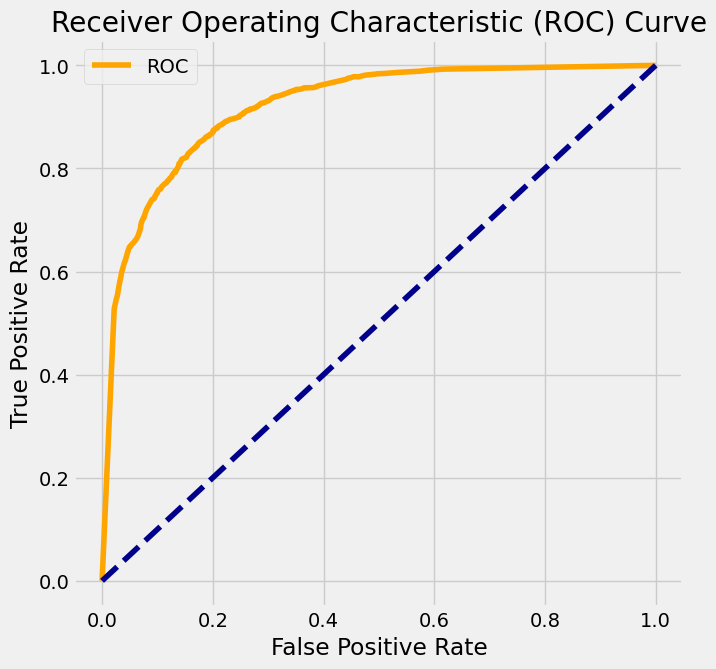

In [49]:
plot_roc_curve(testLabels, # Actual labels
               positiveProbabilities, # Prediction scores for the positive class
               pos_label = 1 # Indicate the label that corresponds to the positive class
              )

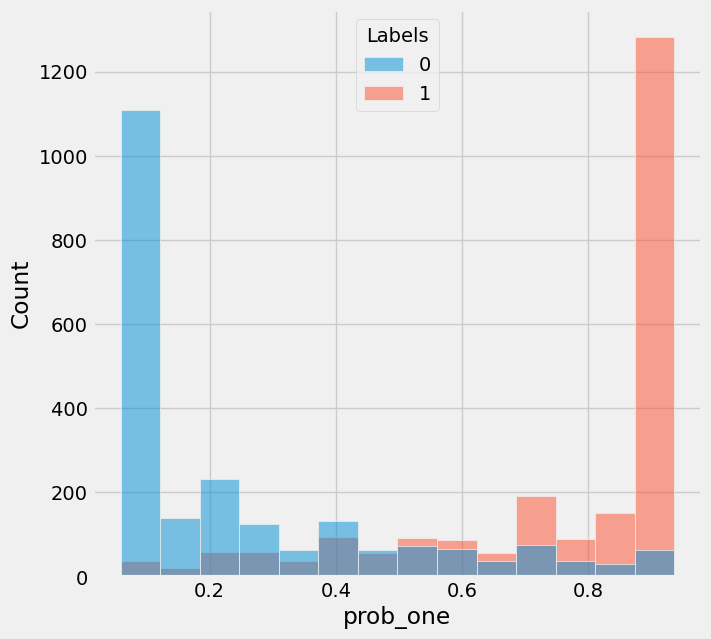

In [50]:
temp = pd.DataFrame(positiveProbabilities)
temp.columns = ["prob_one"]
temp["Labels"] = testLabels

sns.histplot(data=temp, x="prob_one", hue="Labels")
plt.show()

In [51]:
log_loss(testLabels,positiveProbabilities)

0.3624905782390574

In [31]:
# import pickle

In [52]:
with open('team8_hf_app.pkl', 'wb') as file:
    pickle.dump(xgb, file)
    
print("Model has saved as 'team8_hf_app.pkl'")

Model has saved as 'team8_hf_app.pkl'


For our app, we want to pull the mean scores of our selected variables for the Housekeeping department, as that is the segment se chose to concentrate on. We do that with the line of code below, looking at Department 21. We will then use these means to create an employee profile in our Hugging Face examples.

In [12]:
trainData.groupby ("Department", as_index = False) [["SupportiveGM", "WorkEnvironment", "WellBeing", "Engagement", "JobSecurity"]].agg("mean")

,Department,SupportiveGM,WorkEnvironment,WellBeing,Engagement,JobSecurity
0,1,4.337792,4.341558,4.201299,4.415584,4.181818
1,2,4.784025,4.773522,4.600629,4.801887,4.691824
2,5,4.248392,4.340943,4.426987,4.576710,4.304991
3,6,4.230782,4.363128,4.287709,4.402235,4.229050
4,7,4.270725,4.376190,4.376394,4.434015,4.276952
5,8,4.220556,4.284545,4.323232,4.424242,4.252525
6,9,4.207632,4.333333,4.298246,4.438596,4.219298
7,10,3.926364,4.389870,4.415584,4.506494,4.441558
8,12,4.231053,4.339032,4.307368,4.455789,4.334737
9,13,4.247727,4.351288,4.363636,4.517045,4.303030
